<a href="https://colab.research.google.com/github/lalva224/API_Call/blob/main/Credit_Card_Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
#better to combine datasets so i can pre process all at once. Plus training only lets me do 1 dataset.
#this dataset has rows that are missing columns, just skip those.
# df_test = pd.read_csv('fraudTrain.csv',on_bad_lines='skip',index_col=False)
df = pd.read_csv('fraudTrain.csv',index_col=False)[:100000]
# df_test = pd.read_csv('fraudTest.csv',index_col=False)
# df = pd.concat([df_test,df_train])
# df


Text(0.5, 1.0, 'Fraudulent Transactions in test data')

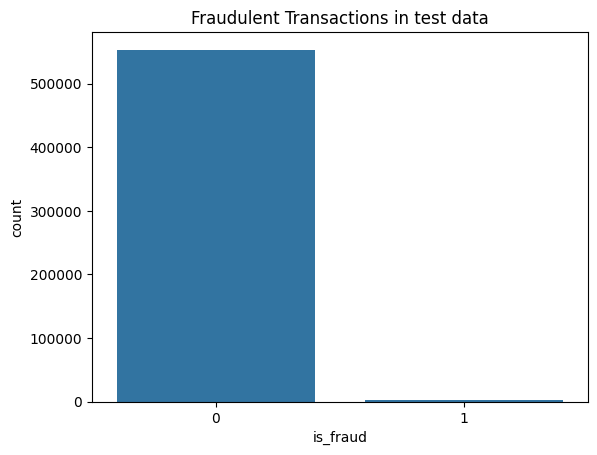

In [3]:
sns.countplot(x='is_fraud',data=df_test)
plt.title('Fraudulent Transactions in test data')
#all of the transactions are not fraudulent. Let's use some SMOTE here to syntheitcally balance our dataset


In [3]:
#need to preprocess and train before using SMOTE
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)


target = df['is_fraud']
#instead of dropping entirely, I can use as a category type. This helps remove duplicates but also represent the category as an integer. While not as helpful the model as one-hot encoding it is better than dropping it.
features = df.drop(['Unnamed: 0','is_fraud','cc_num','trans_num','first','last','street','trans_date_trans_time','merchant','city','zip','lat','long','city_pop','unix_time','merch_lat','merch_long','amt'],axis=1)
categorical_columns = ['state','category',]
# features['state'] = features['state'].astype('category')
# features['category'] = features['category'].astype('category')
#get integer codes here. Some ML models may view one job as greater than another because they are now numbers. Better than dropping such an important column though.
features['job'] = features['job'].astype('category').cat.codes
features['state'] = features['state'].astype('category').cat.codes
features

,category,gender,state,job,dob
0,misc_net,F,NC,359,1988-03-09
1,grocery_pos,F,WA,414,1978-06-21
2,entertainment,M,ID,297,1962-01-19
3,gas_transport,M,MT,318,1967-01-12
4,misc_pos,M,VA,112,1986-03-28
...,...,...,...,...,...
99995,home,M,MN,251,1993-10-12
99996,personal_care,M,LA,216,1994-05-31
99997,food_dining,M,OH,284,1961-09-10
99998,health_fitness,M,ND,5,1983-03-20


In [4]:
from datetime import datetime
current_year = datetime.now().year
#first lets get our date strings as datetime objects so we can access the year. errors='coerce' throws error if incorrect date time format.
features['dob'] = pd.to_datetime(features['dob'],errors='coerce')
#pandas lets us perform element wise operations across entire columns. It also allows us to grab a datetime string and convert it to a datetime object by just .dt from there i can grab year very easily
features['age'] = current_year - features['dob'].dt.year
features['ageGroup'] = pd.cut(features['age'],bins=[18,35,55,70,100],labels=['young','middle-aged','senior','elderly'])

#now we don't need dob anymore
features = features.drop(['dob'],axis=1)


In [5]:

#there's so many
features = pd.get_dummies(features,columns=['gender','category','state','ageGroup'])
features

,job,age,gender_F,gender_M,category_entertainment,category_food_dining,category_gas_transport,category_grocery_net,category_grocery_pos,category_health_fitness,...,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,ageGroup_young,ageGroup_middle-aged,ageGroup_senior,ageGroup_elderly
0,359,36,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
1,414,46,True,False,False,False,False,False,True,False,...,False,False,True,False,False,False,False,True,False,False
2,297,62,False,True,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
3,318,57,False,True,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,True,False
4,112,38,False,True,False,False,False,False,False,False,...,True,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,251,31,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
99996,216,30,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
99997,284,63,False,True,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
99998,5,41,False,True,False,False,False,False,False,True,...,False,False,False,False,False,False,False,True,False,False


In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE


In [7]:
X_train, X_test, y_train, y_test = train_test_split(features,target,test_size=0.2,random_state=42)


In [8]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [12]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
X_test, y_test = smote.fit_resample(X_test, y_test)

Text(0.5, 1.0, 'Resampled Fraudulent transactions')

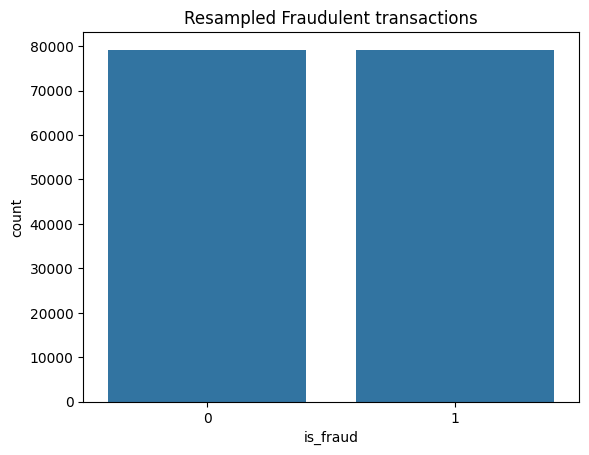

In [ ]:
sns.countplot(x=y_train_resampled)
plt.title('Resampled Fraudulent transactions')

In [10]:
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb

def evaluate_and_save_model(model,X_train,X_test,y_train,y_test,file_name):
  model.fit(X_train,y_train)
  y_pred = model.predict(X_test)
  accuracy = accuracy_score(y_test,y_pred)
  print(f'Model:{model.__class__.__name__}')
  print(f"Accuracy: {accuracy:.2f} %")
  print(f'Classification Report: \n{classification_report(y_test,y_pred)}')
  print('------------------------------------------')
  with open(file_name,'wb') as file:
    pickle.dump(model,file)



In [13]:
rf_model = RandomForestClassifier(random_state=42)
evaluate_and_save_model(rf_model,X_train_resampled,X_test,y_train_resampled,y_test,'rf_model.pkl')

dt_model = DecisionTreeClassifier(random_state=42)
evaluate_and_save_model(dt_model,X_train_resampled,X_test,y_train_resampled,y_test,'dt_model.pkl')

# svm_model = SVC(random_state=42,kernel='linear')
# evaluate_and_save_model(svm_model,X_train_resampled,X_test,y_train_resampled,y_test,'svm_model.pkl')

lr_model = LogisticRegression(random_state=42)
evaluate_and_save_model(lr_model,X_train_resampled,X_test,y_train_resampled,y_test,'lr_model.pkl')

knn_model = KNeighborsClassifier()
evaluate_and_save_model(knn_model,X_train_resampled,X_test,y_train_resampled,y_test,'knn_model.pkl')

nb_model = GaussianNB()
evaluate_and_save_model(nb_model,X_train_resampled,X_test,y_train_resampled,y_test,'nb_model.pkl')

xgb_model = xgb.XGBClassifier(random_state=42)
evaluate_and_save_model(xgb_model,X_train_resampled,X_test,y_train_resampled,y_test,'xgb_model.pkl')

Model:RandomForestClassifier
Accuracy: 0.95 %
Classification Report: 
              precision    recall  f1-score   support

         0.0       0.92      0.99      0.95     19796
         1.0       0.98      0.92      0.95     19796

    accuracy                           0.95     39592
   macro avg       0.95      0.95      0.95     39592
weighted avg       0.95      0.95      0.95     39592

------------------------------------------
Model:DecisionTreeClassifier
Accuracy: 0.93 %
Classification Report: 
              precision    recall  f1-score   support

         0.0       0.89      0.99      0.94     19796
         1.0       0.98      0.88      0.93     19796

    accuracy                           0.93     39592
   macro avg       0.94      0.93      0.93     39592
weighted avg       0.94      0.93      0.93     39592

------------------------------------------
Model:LogisticRegression
Accuracy: 0.75 %
Classification Report: 
              precision    recall  f1-score   support


In [14]:
#i could try hyper parameter tuning or just do stacking and voting classifier
#lets do voting:
from sklearn.ensemble import VotingClassifier

voting_clf_soft = VotingClassifier(estimators=[('rf',RandomForestClassifier(random_state=42)),('xgb',xgb.XGBClassifier(randomstate=42))],voting='soft')
evaluate_and_save_model(voting_clf_soft,X_train_resampled,X_test,y_train_resampled,y_test,'voting_clf_soft.pkl')

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:50:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "randomstate" } are not used.

  warnings.warn(smsg, UserWarning)


Model:VotingClassifier
Accuracy: 0.96 %
Classification Report: 
              precision    recall  f1-score   support

         0.0       0.94      0.99      0.96     19796
         1.0       0.98      0.94      0.96     19796

    accuracy                           0.96     39592
   macro avg       0.96      0.96      0.96     39592
weighted avg       0.96      0.96      0.96     39592

------------------------------------------


In [ ]:
voting_clf_hard = VotingClassifier(estimators=[('rf',RandomForestClassifier(random_state=42)),('xgb',xgb.XGBClassifier(randomstate=42))],voting='hard')
evaluate_and_save_model(voting_clf_soft,X_train_resampled,X_test,y_train_resampled,y_test,'voting_clf_soft.pkl')

In [15]:

from sklearn.ensemble import StackingClassifier

meta_model = xgb.XGBClassifier(random_state=42)
base_models = [('rf',RandomForestClassifier(random_state=42)),('xgb',xgb.XGBClassifier(randomstate=42))]

stacking_clf = StackingClassifier(estimators=base_models,final_estimator=meta_model,cv=5)
evaluate_and_save_model(stacking_clf,X_train_resampled,X_test,y_train_resampled,y_test,'stacking_clf.pkl')


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:53:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "randomstate" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:55:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "randomstate" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:55:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "randomstate" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:55:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "randomstate" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:55:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "randomstate" } are not used.

  war

Model:StackingClassifier
Accuracy: 0.96 %
Classification Report: 
              precision    recall  f1-score   support

         0.0       0.94      0.99      0.96     19796
         1.0       0.98      0.93      0.96     19796

    accuracy                           0.96     39592
   macro avg       0.96      0.96      0.96     39592
weighted avg       0.96      0.96      0.96     39592

------------------------------------------


In [16]:

meta_model = xgb.XGBClassifier(random_state=42)
base_models = [('rf',RandomForestClassifier(random_state=42)),('xgb',xgb.XGBClassifier(randomstate=42))]

stacking_clf = StackingClassifier(estimators=base_models,final_estimator=meta_model)
evaluate_and_save_model(stacking_clf,X_train_resampled,X_test,y_train_resampled,y_test,'stacking_clf.pkl')

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:56:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "randomstate" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:58:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "randomstate" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:58:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "randomstate" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:58:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "randomstate" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:58:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "randomstate" } are not used.

  war

Model:StackingClassifier
Accuracy: 0.96 %
Classification Report: 
              precision    recall  f1-score   support

         0.0       0.94      0.99      0.96     19796
         1.0       0.98      0.93      0.96     19796

    accuracy                           0.96     39592
   macro avg       0.96      0.96      0.96     39592
weighted avg       0.96      0.96      0.96     39592

------------------------------------------
